Here I will look at the effect of grid spacing on if the wave can move forward. The expectation is that the wave gets stuck when the grid spacing is comparable to the dispersal distance. Because the Carroll ZOI dispersal distance is so large, this is unrealistic for the effects of grid size. Instead here, we use the smaller value of $\alpha=0.1$ to be more able to see the effects.

In [9]:
import spatialfunctions as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.patches import Rectangle
from IPython.display import clear_output

In [16]:
plt.rcParams['font.family'] = 'serif'

# Make plot colors and things to make it easier to be consistent
# Old
#cmap = plt.cm.get_cmap('Greens').reversed().copy()
#cmap.set_bad(color=plt.cm.get_cmap('PiYG')(0))

cmap2norm = plt.cm.get_cmap('PiYG')
# New with hatches
cmap = plt.cm.get_cmap('Greens').reversed().copy()
hatchc = plt.cm.get_cmap('PiYG')(0)

# Figsize consistent
figsize = (3,3)

/var/folders/l1/prbyqvgx4mg745chvp4d8x3r0000gn/T/ipykernel_21117/3757525426.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2norm = plt.cm.get_cmap('PiYG')
/var/folders/l1/prbyqvgx4mg745chvp4d8x3r0000gn/T/ipykernel_21117/3757525426.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greens').reversed().copy()
/var/folders/l1/prbyqvgx4mg745chvp4d8x3r0000gn/T/ipykernel_21117/3757525426.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  hatchc =

In [17]:
# Set params
s = 0.99
N = 60
c = 1300
al= 0.1

# Use a range of thresholds
plist = np.arange(150,375,25)
plen = len(plist)

# Set up grid to be appropriate for the smaller dispersal kernel.
xrexp = 14;
# Have various values of dx
dxlist = np.logspace(2,7,base=2,num=6,dtype=int)#[4,8,16,32,64,128]
dxlen = len(dxlist)

In [18]:
# Test if the wave moves. Save the speed.

# Number of steps
nt = 200
# Speeds to save
speed = np.zeros([plen,dxlen])


# Loop through g's and dx's
for j,dx in enumerate(dxlist):
    # Get xr for this dx
    xr = np.arange(-2**xrexp,2**xrexp+dx,step=dx)
    for i,p in enumerate(plist):
        # Print progress
        print(j+1,"/",dxlen," ",i+1,"/",plen)
        clear_output(wait=True)
        
        # Get fopt
        fopt = sf.getfopt(p,c)

        # First, check to make sure 1-F = m/c exists. 
        # We only need to do this for phi/c > 0.75 (this seems numerically true)
        if p/c>0.75:
            # This returns the value where (1-F)/m is maximized, which we can put in as a bound
            # Or returns an empty array, meaning no solution exists.
            mmax = sf.outbreak_existence(fopt,c)
            if mmax.size>0:
                # If it returns a value, get the initial conditions
                x0 = sf.get_x0even(xrexp,dx,fopt,c,s,N,bracket=[mmax,c+1])
            else:
                # If it is empty, set this array to empty which we will check later
                x0 = np.array([])
        # If the params are not that close to 0.75, we can just call this function directly
        else:
            x0 = sf.get_x0even(xrexp,dx,fopt,c,s,N)
            
         # If after that we have an initial condition to run from, simulate the wave
        if x0.size>0:
            wave = sf.iterate(xr,nt,fopt,x0,al,c,s,N,dx=dx)

            # Find the argument where the first transient outbreak occurs at x=1
            argmax = sf.outbreak_occurs(wave,N,xrexp,dx)

            # Only calculate everything if the outbreak actually occurs
            if (argmax.size>0):
                # Get speed
                # First check if the wave collides with the backward wave, only calculate the speed up to that arg
                argcol = sf.collision_arg(wave,N,xrexp,dx)
                speed[i,j] = sf.getspeed(wave,argcol,N,xrexp,dx)
        del wave

6 / 6   9 / 9


In [19]:
# Make a mask for speed=0
speed = np.ma.array(speed, mask=(speed == 0))

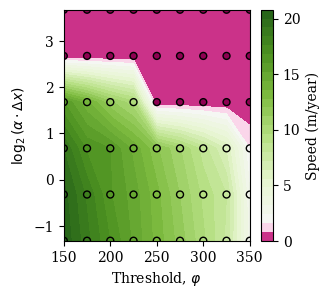

In [20]:
# OLD PLOT
# Plot the speeds with contours and dots
# Get color norm. Set it so that the center is at the minimum speed, and 0 is the darkest.
norm = TwoSlopeNorm(vmin=0, vcenter=np.min([5,speed[speed>0].min()]), vmax=speed.max())

# Get grid to plot on
X,Y=np.meshgrid(plist,np.log2(al*dxlist))

# Plot the speed for all of these
plt.figure(figsize=figsize)

# Plot speeds with contours
cbar = plt.contourf(X,Y,speed.T.data,levels=30,cmap=cmap2norm,norm=norm)

# Now plot the points as well
plt.scatter(X,Y,c=speed.T.data,edgecolor='k',cmap=cmap2norm,s=5**2,norm=norm)

# Set face colour to be the 0 color
#plt.gca().set_facecolor(plt.cm.get_cmap(cmap)(0)) 

# Plot the colorbar itself
cb = plt.colorbar(cbar,label='Speed (m/year)')
cb.ax.set_yscale('linear')

# Labels
plt.ylabel(r'$\log_2(\alpha \cdot \Delta x)$')
plt.xlabel(r'Threshold, $\varphi$')
plt.savefig('figures/grid_spacing.pdf',bbox_inches='tight')

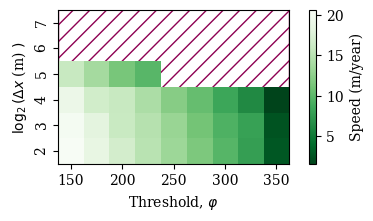

In [21]:
# Plot the speeds with contours and dots

# Plot the speed for all of these
fig, ax = plt.subplots(figsize=(5,2))

# Plot speeds with imshow
cbar = ax.imshow(speed.T,origin='lower',cmap=cmap)
ax.add_patch(Rectangle((-0.5, -0.5), 9, 7, fill=False, hatch='//',edgecolor=hatchc,zorder=-10))

# Plot the colorbar itself
cb = plt.colorbar(cbar,label='Speed (m/year)')
cb.ax.set_yscale('linear')

# Labels
ax.set_ylabel(r'$\log_2(\Delta x$ (m) $)$')
ax.set_xlabel(r'Threshold, $\varphi$')
ax.set_yticks(np.arange(dxlen),np.log2(dxlist).astype(int),rotation=90)
ax.set_xticks(np.arange(plen)[::2],plist.astype(int)[::2],rotation=0)
# Save
fig.savefig('figures/grid_spacing_discrete.pdf',bbox_inches='tight')

# Alpha=0.01

In [22]:
al_01=0.01
dxlist_01 = np.logspace(4,9,base=2,num=6,dtype=int)

# Number of steps
nt = 200
# Speeds to save
speed_01 = np.zeros([plen,dxlen])


# Loop through g's and dx's
for j,dx in enumerate(dxlist_01):
    # Get xr for this dx
    xr = np.arange(-2**xrexp,2**xrexp+dx,step=dx)
    for i,p in enumerate(plist):
        # Print progress
        print(j+1,"/",dxlen," ",i+1,"/",plen)
        clear_output(wait=True)
        
        # Get fopt
        fopt = sf.getfopt(p,c)

        # First, check to make sure 1-F = m/c exists. 
        # We only need to do this for phi/c > 0.75 (this seems numerically true)
        if p/c>0.75:
            # This returns the value where (1-F)/m is maximized, which we can put in as a bound
            # Or returns an empty array, meaning no solution exists.
            mmax = sf.outbreak_existence(fopt,c)
            if mmax.size>0:
                # If it returns a value, get the initial conditions
                x0 = sf.get_x0even(xrexp,dx,fopt,c,s,N,bracket=[mmax,c+1])
            else:
                # If it is empty, set this array to empty which we will check later
                x0 = np.array([])
        # If the params are not that close to 0.75, we can just call this function directly
        else:
            x0 = sf.get_x0even(xrexp,dx,fopt,c,s,N)
            
         # If after that we have an initial condition to run from, simulate the wave
        if x0.size>0:
            wave = sf.iterate(xr,nt,fopt,x0,al_01,c,s,N,dx=dx)

            # Find the argument where the first transient outbreak occurs at x=1
            argmax = sf.outbreak_occurs(wave,N,xrexp,dx)

            # Only calculate everything if the outbreak actually occurs
            if (argmax.size>0):
                # Get speed
                # First check if the wave collides with the backward wave, only calculate the speed up to that arg
                argcol = sf.collision_arg(wave,N,xrexp,dx)
                speed_01[i,j] = sf.getspeed(wave,argcol,N,xrexp,dx)
        del wave

6 / 6   9 / 9


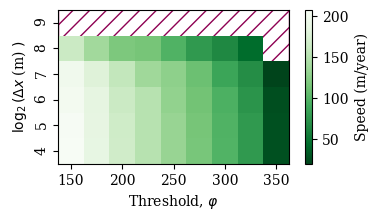

In [23]:
# Make a mask for speed=0
speed_01 = np.ma.array(speed_01, mask=(speed_01 == 0))

# Plot the speed for all of these
fig,ax = plt.subplots(figsize=(4,2))

# Plot speeds with imshow
cbar = ax.imshow(speed_01.T,origin='lower',cmap=cmap)
ax.add_patch(Rectangle((-0.5, -0.5), 9, 7, fill=False, hatch='//',edgecolor=hatchc,zorder=-10))

# Plot the colorbar itself
cb = plt.colorbar(cbar,label='Speed (m/year)')
cb.ax.set_yscale('linear')

# Labels
ax.set_ylabel(r'$\log_2(\Delta x$ (m) $)$')
ax.set_xlabel(r'Threshold, $\varphi$')
ax.set_yticks(np.arange(dxlen),np.log2(dxlist_01).astype(int),rotation=90)
ax.set_xticks(np.arange(plen)[::2],plist.astype(int)[::2],rotation=0)
# Save
fig.savefig('figures/grid_spacing_discrete_al01.pdf',bbox_inches='tight')

# Plot both together

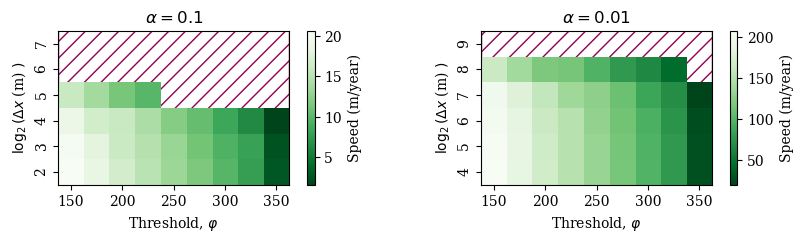

In [24]:
# Plot the speeds with contours and dots

# Plot the speed for all of these
fig,axs = plt.subplots(1,2,figsize=(10,2))

# Plot speeds with imshow
cbar = axs[0].imshow(speed.T,origin='lower',cmap=cmap,vmin=np.min(speed),vmax=np.max(speed))
cbar1 = axs[1].imshow(speed_01.T,origin='lower',cmap=cmap,vmin=np.min(speed_01),vmax=np.max(speed_01))
for ax in axs:
    ax.add_patch(Rectangle((-0.5, -0.5), 9, 7, fill=False, hatch='//',edgecolor=hatchc,zorder=-10))

# Plot the colorbar itself
cb = fig.colorbar(cbar,label='Speed (m/year)',ax=axs[0])
#cb.ax.set_yscale('linear')
cb1 = fig.colorbar(cbar1,label='Speed (m/year)',ax=axs[1])

# Labels
axs[0].set_title(r'$\alpha=0.1$')
axs[1].set_title(r'$\alpha=0.01$')
axs[0].set_ylabel(r'$\log_2(\Delta x$ (m) $)$')
axs[1].set_ylabel(r'$\log_2(\Delta x$ (m) $)$')
axs[0].set_xlabel(r'Threshold, $\varphi$')
axs[1].set_xlabel(r'Threshold, $\varphi$')
axs[0].set_yticks(np.arange(dxlen),np.log2(dxlist).astype(int),rotation=90)
axs[0].set_xticks(np.arange(plen)[::2],plist.astype(int)[::2],rotation=0)
axs[1].set_yticks(np.arange(dxlen),np.log2(dxlist_01).astype(int),rotation=90)
axs[1].set_xticks(np.arange(plen)[::2],plist.astype(int)[::2],rotation=0)
# Save
plt.savefig('figures/grid_spacing_discrete_alboth.pdf',bbox_inches='tight')